In [7]:
from citalopram_project.load import load_spikes, load_neurons

from citalopram_project.transforms import pivot
from neurobox.compose import Pipeline
import pandas as pd
from spiketimes.df.statistics import ifr_by
from scipy.stats import zmap, zscore
import numpy as np
import seaborn as sns
from spiketimes.utils import p_adjust
from ezbootstrap import permutation_2sample
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

neurons = load_neurons().loc[lambda x: x.group.isin(["sal", "continuation"])]
chal_spikes = load_spikes("chal").merge(neurons[["neuron_id", "cluster", "session_name", "group"]]).loc[lambda x: x.spiketimes <= 1200]

In [11]:
# assign responders

def permutation_around_baseline(df, func, baseline_before=0, n_boot=1000, how="two_sided"):
        def _apply_around_col(col, baseline_before, func_, how, n_boot=n_boot):         
            x = col.loc[lambda x: x.index <=  baseline_before].values
            y = col.loc[lambda x: x.index >  baseline_before].values
            obs = func_(x, y)
            reps = permutation_2sample(x, y, func_, size=n_boot)
            if how == "two_sided":
                p = (np.abs(reps) >= np.abs(obs)).mean() * 2
            elif how == "lower":
                p = (reps <= obs).mean()
            elif how == "upper":
                p = (reps >= obs).mean()
            else:
                raise ValueError("Unknow value for how param")
            return pd.Series({"statistic": obs, "p": p})
        return df.apply(_apply_around_col, func_=func, baseline_before=baseline_before, how=how).transpose().reset_index().assign(p_adj = lambda x: p_adjust(x.p), how=how)

def bin_spikes(df, binwidth, gaussian_sigma=None):
    return ifr_by(df, fs=1/binwidth, sigma=gaussian_sigma, spiketrain_col="neuron_id")


def round_index(df, precision=0):
    df.index = np.round(df.index, precision)
    return df

def exclude_baseline(df, baseline_before=0, min_baseline_fr=0.2):
    idx = df.apply(lambda x: x.loc[x.index < baseline_before].mean() > min_baseline_fr).tolist()
    return df.loc[:, idx]


pipe = Pipeline(steps=
    [
        (bin_spikes, dict(binwidth=60, gaussian_sigma=None)),
        (pivot, dict(value_col= "ifr")),
        (round_index, dict()),
        (exclude_baseline, dict(baseline_before=0.2, min_baseline_fr=0.2)),
        (permutation_around_baseline, dict(func=lambda x, y: x.mean() - y.mean(), n_boot=1000, how="upper")),
    ]
)

In [12]:
# bin_spikes(chal_spikes, binwidth=60, gaussian_sigma=None)

Proportion test: (3.358477684160282, 0.0007837304903881767)
Statistic test: MannwhitneyuResult(statistic=240.0, pvalue=3.777295608514409e-07)


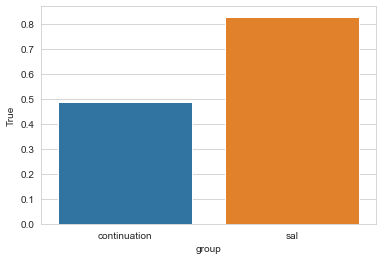

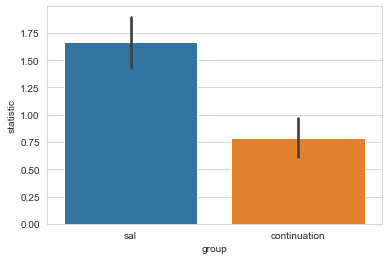

In [16]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

res_cit = pipe.transform(chal_spikes).merge(neurons[["neuron_id", "cluster", "group"]]).loc[lambda x: x.cluster == "slow_regular"].assign(sig=lambda x: x.p_adj < 0.05)
dfp = res_cit.loc[lambda x: x.cluster == "slow_regular"]

plt.figure()
(
    dfp.groupby("group")["sig"]
    .value_counts(normalize=True).unstack()
    .reset_index()
    .pipe((sns.barplot, "data"), x="group", y=True)
)
plt.savefig("CIT PROP.svg")
counts = [34, 43]
n_obs = [42, 86]
prop_res = proportions_ztest(counts, n_obs)

plt.figure()
(
    dfp.loc[lambda x: x.sig == True]
    .pipe((sns.barplot, "data"), x="group", y="statistic")
)
plt.savefig("CIT MAG.svg")

x = dfp.loc[lambda x: (x.sig == True) & (x.group == "sal")]["statistic"]
y = dfp.loc[lambda x: (x.sig == True) & (x.group == "continuation")]["statistic"]
res_effect = mannwhitneyu(x, y)

print(f"Proportion test: {prop_res}")
print(f"Statistic test: {res_effect}")

In [20]:
dfp.groupby("group").apply(len)

group
continuation    86
sal             41
dtype: int64

In [21]:
dfp.groupby("group").apply(lambda x: (x.p_adj < 0.05).mean())

group
continuation    0.488372
sal             0.829268
dtype: float64

In [22]:
dfp.groupby("group").apply(lambda x: x.statistic.mean())

group
continuation    0.214986
sal             1.279723
dtype: float64

In [166]:
# other neurons

(
    pipe.transform(chal_spikes)
    .merge(neurons[["neuron_id", "cluster", "session_name", "group"]])
    .assign(sig=lambda x: x.p_adj < 0.05)
    .pivot_table(columns="group",index="cluster", values=["sig", "statistic"])
)

sig              statistic             
group                sal continuation       sal continuation
cluster                                                     
fast_firing     0.666667     0.555556  0.876622     0.209694
slow_irregular  0.523810     0.406977  0.954863     0.088947
slow_regular    0.809524     0.500000  1.214007     0.214986

In [167]:
nums = pipe.transform(chal_spikes)

In [26]:
# create SR heatmaps

def split_by_group(df):
    return {gname: df.loc[lambda x: x.group == gname] for gname in df["group"].unique()}


def pivot(df, time_col="time", value_col="ifr", neuron_col="neuron_id"):
    return pd.pivot(df, index=time_col, values=value_col, columns=neuron_col)

def standardize(df, baseline_before=None):
    def _standardize_col(col, baseline_before=None):
        if baseline_before is not None:
            return zmap(col, col.loc[lambda x: x.index < baseline_before])
        else:
            return zscore(col)
    return df.apply(_standardize_col, baseline_before=baseline_before)



def select_neuron_type(df, neuron_df, neuron_type):
    neurons_of_interest = neuron_df.loc[lambda x: x.cluster == neuron_type].neuron_id.unique()
    return df.loc[:, [n for n in df.columns if n in neurons_of_interest]]

def sort_by_inhibition(df):
    idx = df.loc[lambda x: x.index > 0].mean().sort_values().index.tolist()
    return df[idx]


pipe = Pipeline(steps=
    [
        (bin_spikes, dict(binwidth=1, gaussian_sigma=1)),
        (pivot, dict()),
        (round_index, dict()),
        (exclude_baseline, dict(baseline_before=0.2)),
        (standardize, dict(baseline_before=0)),
        (select_neuron_type, dict(neuron_df=neurons, neuron_type="slow_regular")),
        (sort_by_inhibition, dict())
    ]
)

In [159]:
by_group = split_by_group(chal_spikes)

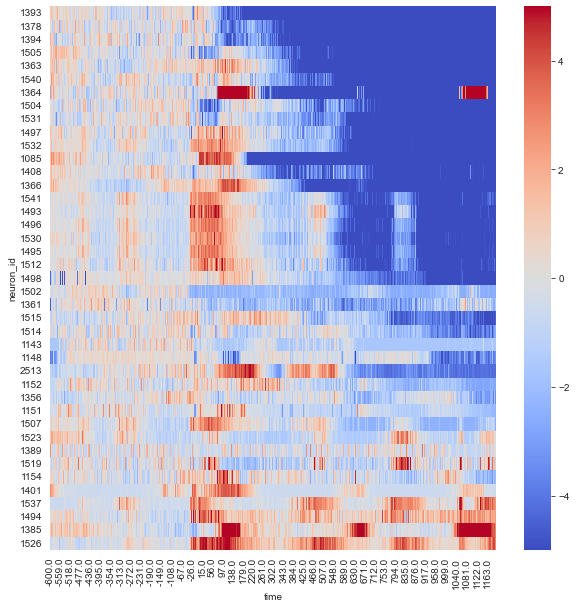

In [160]:
df =by_group["sal"]
dfp = pipe.transform(df)
plt.figure(figsize=(10,10))
sns.heatmap(dfp.transpose(), vmin=-5, vmax=+5, cmap="coolwarm")
plt.savefig("SAL CIT HEAT.png", dpi=300)

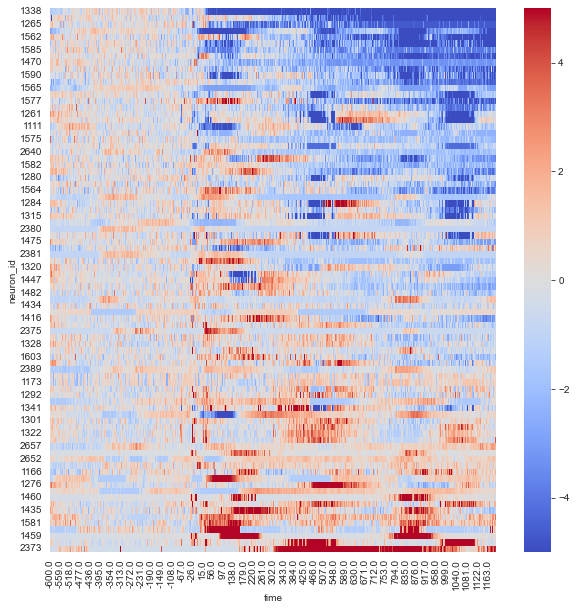

In [161]:
df =by_group["continuation"]
dfp = pipe.transform(df)
plt.figure(figsize=(10,10))
sns.heatmap(dfp.transpose(), vmin=-5, vmax=+5, cmap="coolwarm")
plt.savefig("CONTINUATION CIT HEAT.png", dpi=300)

In [32]:
# WAY


way_spikes = load_spikes("way").merge(neurons[["neuron_id", "cluster", "session_name", "group"]]).loc[lambda x: x.spiketimes <= 1200]

In [36]:
way_spikes = way_spikes.merge(res_cit.loc[lambda x: (x.p_adj < 0.05) & (x.cluster == "slow_regular")][["neuron_id"]])

In [46]:
pipe = Pipeline(steps=
    [
        (bin_spikes, dict(binwidth=60, gaussian_sigma=None)),
        (pivot, dict()),
        (round_index, dict()),
        # (exclude_baseline, dict(baseline_before=0.2, min_baseline_fr=0.2)),
        (permutation_around_baseline, dict(func=lambda x, y: x.mean() - y.mean(), n_boot=1000, how="lower")),
    ]
)

Proportion test: (3.1046241838428443, 0.0019052093075058773)


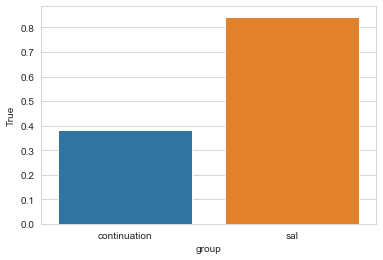

In [47]:
dfp = pipe.transform(way_spikes).merge(neurons[["neuron_id", "group"]]).assign(sig=lambda x: x.p_adj < 0.05)

plt.figure()
(
    dfp.groupby("group")["sig"]
    .value_counts(normalize=True).unstack()
    .reset_index()
    .pipe((sns.barplot, "data"), x="group", y=True)
)
plt.savefig("PROP WAY.svg")
counts = [15, 13]
n_obs = [19, 37]
prop_res = proportions_ztest(counts, n_obs)

print(f"Proportion test: {prop_res}")
# print(f"Statistic test: {res_effect}")

res_way = dfp

In [75]:
res_way.groupby("group").apply(len)

group
continuation    42
sal             32
dtype: int64

In [83]:
res_way

,neuron_id,statistic,p,p_adj,how,group,sig
0,1111,1.780994,1.000,1.000000,lower,continuation,False
1,1143,0.176457,0.939,1.000000,lower,sal,False
2,1148,0.300191,0.997,1.000000,lower,sal,False
3,1152,-0.994262,0.000,0.000000,lower,sal,True
4,1261,-2.231355,0.000,0.000000,lower,continuation,True
...,...,...,...,...,...,...,...
69,2375,1.905772,1.000,1.000000,lower,continuation,False
70,2380,-0.072820,0.274,0.440783,lower,continuation,False
71,2381,1.107208,1.000,1.000000,lower,continuation,False
72,2513,0.008214,0.962,1.000000,lower,sal,False


In [84]:
res_way.groupby("group").apply(lambda x: (x.sig).mean())

group
continuation    0.380952
sal             0.843750
dtype: float64

In [71]:
res_way.loc[lambda x: x.statistic > 0].groupby("group").apply(lambda x: x.statistic.mean())

group
continuation    1.036969
sal             0.419717
dtype: float64

In [72]:
# res_way.groupby("")

In [50]:
pipe = Pipeline(steps=
    [
        (bin_spikes, dict(binwidth=1, gaussian_sigma=1)),
        (pivot, dict()),
        (round_index, dict()),
        # (exclude_baseline, dict(baseline_before=0.2)),
        # (standardize, dict(baseline_before=0)),
        (select_neuron_type, dict(neuron_df=neurons, neuron_type="slow_regular")),
        (sort_by_inhibition, dict())
    ]
)

In [51]:
res_cit = res_cit.merge(neurons[["neuron_id", "cluster", "group"]]).assign(sig=lambda x: x.p_adj < 0.05)
res_cit = res_cit.loc[lambda x: x.cluster == "slow_regular"]

In [60]:
res_way.groupby("group").apply(lambda x: x.sig.mean())

group
continuation    0.380952
sal             0.843750
dtype: float64

In [62]:
res_way.groupby("group").statistic.mean()

,neuron_id,statistic,p,p_adj,how,group,sig
0,1111,1.780994,1.000,1.000000,lower,continuation,False
1,1143,0.176457,0.939,1.000000,lower,sal,False
2,1148,0.300191,0.997,1.000000,lower,sal,False
3,1152,-0.994262,0.000,0.000000,lower,sal,True
4,1261,-2.231355,0.000,0.000000,lower,continuation,True
...,...,...,...,...,...,...,...
69,2375,1.905772,1.000,1.000000,lower,continuation,False
70,2380,-0.072820,0.274,0.440783,lower,continuation,False
71,2381,1.107208,1.000,1.000000,lower,continuation,False
72,2513,0.008214,0.962,1.000000,lower,sal,False


In [44]:
df1

""
0
1
2
3
4
5
6
7
8
9


In [40]:
by_group = split_by_group(way_spikes)

sr_inhibited_sal = res_cit.loc[lambda x: (x.group == "sal") & (x.cluster == "slow_regular") & (x.p_adj < 0.05)]["neuron_id"].values
df = by_group["sal"]
dfp = pipe.transform(df)
dfp =dfp[[col for col in dfp.columns if col in sr_inhibited_sal]]
df1 = dfp.reset_index().melt(id_vars="time").dropna()


sr_inhibited_cit = res_cit.loc[lambda x: (x.group == "continuation") & (x.cluster == "slow_regular") & (x.p_adj < 0.05)]["neuron_id"].values
df = by_group["continuation"]
dfp = pipe.transform(df)
dfp =dfp[[col for col in dfp.columns if col in sr_inhibited_cit]]

df2 = dfp.reset_index().melt(id_vars="time").dropna()


dfp = pd.concat([df1.assign(group="sal"), df2.assign(group="cit")]).reset_index(drop=True)

_, ax = plt.subplots(figsize=(4, 2))

sns.lineplot(data=dfp, x="time", y="value", hue="group", ax=ax, ci=90)
plt.savefig("WAY-line.svg")


c:\Users\roryl\.conda\envs\citalopram\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


KeyError: 'time'

<AxesSubplot:xlabel='time', ylabel='value'>

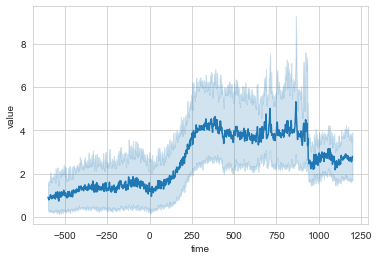

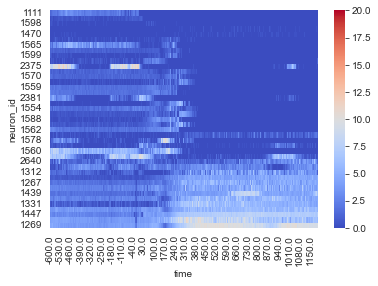

In [131]:
sr_inhibited_cit = res_cit.loc[lambda x: (x.group == "continuation") & (x.cluster == "slow_regular") & (x.p_adj < 0.05)]["neuron_id"].values
df = by_group["continuation"]
dfp = pipe.transform(df)
dfp =dfp[[col for col in dfp.columns if col in sr_inhibited_cit]]
sns.heatmap(dfp.transpose(), 
vmin=0, vmax=+20, 
cmap="coolwarm")

df2 = dfp.reset_index().melt(id_vars="time").dropna()

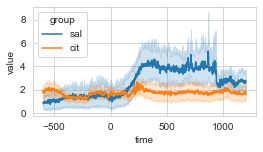

In [141]:
dfp = pd.concat([df1.assign(group="sal"), df2.assign(group="cit")]).reset_index(drop=True)

_, ax = plt.subplots(figsize=(4, 2))

sns.lineplot(data=dfp, x="time", y="value", hue="group", ax=ax, ci=90)
plt.savefig("WAY-line.svg")


<AxesSubplot:xlabel='time', ylabel='value'>

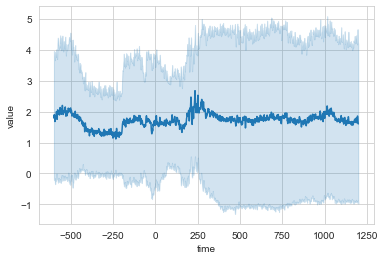

In [126]:
(
    dfp.reset_index().melt(id_vars="time").dropna()
    .pipe((sns.lineplot, "data"), x="time", y="value", ci="sd")
)

In [64]:
dfp

,neuron_id,statistic,p,p_adj,how
0,1143,0.176453,0.041,0.149650,upper
1,1144,0.475417,0.000,0.000000,upper
2,1145,0.109413,0.295,0.861400,upper
3,1146,-1.218225,1.000,1.000000,upper
4,1148,0.300065,0.000,0.000000,upper
...,...,...,...,...,...
68,2512,-1.596178,1.000,1.000000,upper
69,2515,0.122053,0.293,0.861400,upper
70,2516,-0.256958,0.909,1.000000,upper
71,2517,0.445198,0.051,0.177286,upper


In [24]:
from citalopram_project.correlations import pairwise_correlation_spikes, pairwise_correlation, shuffled_isi_correlation_test
from citalopram_project.transforms import  bin_spikes_interval, pivot, gaussian_smooth
from citalopram_project.load import load_spikes, load_neurons
from neurobox.compose import Pipeline

neurons = load_neurons()
chal_spikes = load_spikes("chal").merge(neurons[["neuron_id", "cluster", "session_name", "group"]]).loc[lambda x: x.spiketimes <= 1200]
df1 = chal_spikes.loc[lambda x: x.session_name == neurons.session_name.unique()[5]]

In [4]:
res = shuffled_isi_correlation_test(df1, n_boot=10, bin_width=1, fillna=0, sigma=0.1, show_progress=True)

100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


In [8]:
(res.p_adj < 0.05).mean()

0.6428571428571429